##check
1.  % with NA that are fraud? do we need to handle NA differenently?  YES  
2.  model evaluations:  
    a.  confusion matrix --> profie curve  
    b.  feature importance   
3.  other potentially useful features?
4.  scale the data?
5.  test out different methods
6. set up hyper parameter search overnight

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## questions:
1. lattitude, longitude: have high feature importance as continuous variable, but many fraud case have missing value;
2.  sales_duration vs. sales_duration2: data leakage?


In [8]:
! ls ../data

loanData.csv   test_new.json  train_new.json


In [9]:
# Reading the train set as a list of dictionaries.
with open('../data/train_new.json') as data_file:    
    train_data = json.load(data_file)

In [11]:
# Reading the train/test data as data frames.
train_df = pd.read_json('../data/train_new.json')
test_df = pd.read_json('../data/test_new.json')

In [305]:
train_df.dtypes

acct_type              object
approx_payout_date      int64
body_length             int64
channels                int64
country                object
currency               object
delivery_method       float64
description            object
email_domain           object
event_created           int64
event_end               int64
event_published       float64
event_start             int64
fb_published            int64
gts                   float64
has_analytics           int64
has_header            float64
has_logo                int64
listed                 object
name                   object
name_length             int64
num_order               int64
num_payouts             int64
object_id               int64
org_desc               object
org_facebook          float64
org_name               object
org_twitter           float64
payee_name             object
payout_type            object
previous_payouts       object
sale_duration         float64
sale_duration2          int64
show_map  

In [12]:
# Copying the train data into another dataframe.
train_df2 = train_df.copy()

In [35]:
# find out the numbers of unique values for each feature
with open('test_tmp.csv', 'w') as o_fh:
    for i, name in enumerate(train_df.columns):
        if name != 'previous_payouts'and name != 'ticket_types':
            print name, len(train_df2.iloc[:,i].unique())
            o_fh.write(','.join([str(t) for t in [name, len(train_df2.iloc[:,i].unique()), "\n"]]))
            

acct_type 12
approx_payout_date 9655
body_length 6595
channels 11
country 73
currency 7
delivery_method 4
description 13095
email_domain 5772
event_created 14335
event_end 9655
event_published 14182
event_start 9274
fb_published 2
gts 9680
has_analytics 2
has_header 3
has_logo 2
listed 2
name 13940
name_length 185
num_order 397
num_payouts 564
object_id 14337
org_desc 5845
org_facebook 82
org_name 9501
org_twitter 24
payee_name 2481
payout_type 3
sale_duration 376
sale_duration2 399
show_map 2
user_age 1597
user_created 10254
user_type 6
venue_address 10142
venue_country 70
venue_latitude 10526
venue_longitude 10515
venue_name 9788
venue_state 443


In [14]:
# find out the numbers of unique values for each feature
for i, name in enumerate(test_df.columns):
    if name != 'previous_payouts'and name != 'ticket_types':
        print name, len(test_df.iloc[:,i].unique())

acct_type 10
approx_payout_date 3148
body_length 2653
channels 11
country 56
currency 6
delivery_method 4
description 3339
email_domain 1892
event_created 3585
event_end 3148
event_published 3540
event_start 3099
fb_published 2
gts 2844
has_analytics 2
has_header 3
has_logo 2
listed 2
name 3543
name_length 145
num_order 225
num_payouts 275
object_id 3585
org_desc 1715
org_facebook 68
org_name 2833
org_twitter 22
payee_name 725
payout_type 3
sale_duration 261
sale_duration2 275
show_map 2
user_age 1105
user_created 3075
user_type 5
venue_address 2780
venue_country 34
venue_latitude 2911
venue_longitude 2912
venue_name 2627
venue_state 246


In [32]:
train_df.head(2).T

,0,1
acct_type,fraudster_event,premium
approx_payout_date,1266062400,1296720000
body_length,3852,3499
channels,5,0
country,US,US
currency,USD,USD
delivery_method,0,1
description,"<p><a href=""http://s432.photobucket.com/albums...","<p>Join us for a quick, one-night, community-b..."
email_domain,gmail.com,ruf.org
event_created,1262739706,1293832670


In [15]:
train_df2['fraud'] = train_df2.acct_type.apply(lambda x: x[0] == 'f')  

In [108]:
cond_fraud = train_df2['fraud'] 
n_events = train_df2.shape[0]
n_frauds = train_df2[cond_fraud].shape[0]

cat_cols = ['org_name', 'venue_name', 'payee_name', 'country',\
           'email_domain', 'name', 'venue_country' ]
print 'summary stats:'
print 'number events: %i, %.2f%% fraud' % (train_df2.shape[0],  100.0 * n_frauds/n_events)
print "by subgroup:"
for v in cat_cols:
    n = train_df2[v].nunique()
    n_w_fraud = train_df2[cond_fraud][v].nunique() 
    print '   number of %s: %i %.2f%% had fraud' %(v, n, 100.0 * n_w_fraud / n)

summary stats:
number events: 14337, 9.02% fraud
by subgroup:
   number of org_name: 9501 5.59% had fraud
   number of venue_name: 9787 6.15% had fraud
   number of payee_name: 2481 1.09% had fraud
   number of country: 72 65.28% had fraud
   number of email_domain: 5772 2.32% had fraud
   number of name: 13940 8.11% had fraud
   number of venue_country: 69 49.28% had fraud


### features currently used

In [50]:
category_variables = ['channels', 'country', 'currency', 'delivery_method', 
                      'fb_published', 'has_analytics', 'has_header', 
                      'has_logo', 'listed', 'payout_type', 'show_map', \
                      'user_type', 'venue_country']
non_category_variables = ['body_length', 'num_payouts', 'sale_duration', 'sale_duration2', 
                          'user_age', 'venue_latitude', 'venue_longitude']
print len(category_variables) + len(non_category_variables)

20


## explore categorical variables

In [260]:

df = train_df2

def plot_cat_var(df, catx_names, y_name):
    fig, axs = plt.subplots(2, len(catx_names), figsize=(10,6))


    for i, cat in enumerate(catx_names):
        avg_pos = df.groupby(cat)[y_name].mean()
        avg_pos.plot(kind='bar', ax=axs[0,i], color='r', alpha = 0.5)
        cnt = df.groupby(cat)[y_name].sum()
        cnt.plot(kind='bar', ax=axs[1,i])
    plt.tight_layout()
    plt.suptitle('%Fraud and Total Counts')
    plt.show()

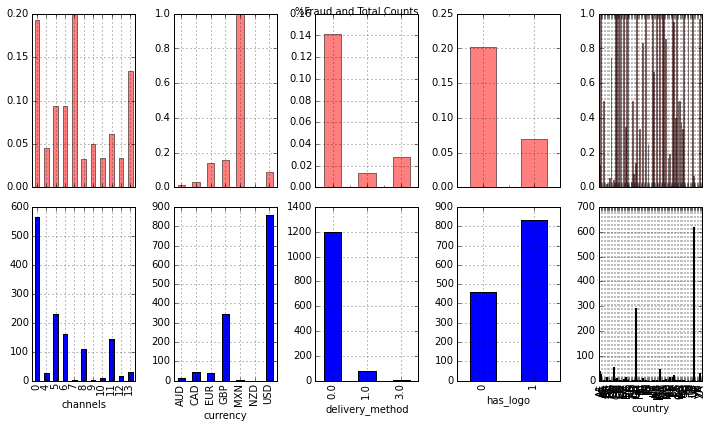

In [263]:
catx_names = ['channels',  'currency', 'delivery_method','has_logo', 'country']
plot_cat_var(df, catx_names, y_name)

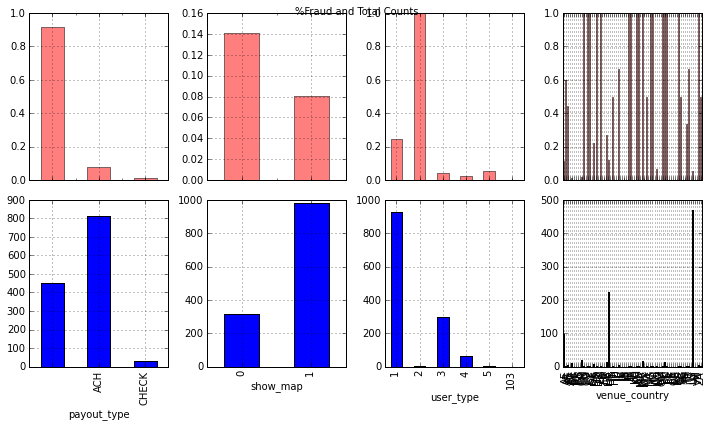

In [262]:
plot_cat_var(df, [ 'payout_type', 'show_map', \
                      'user_type', 'venue_country'], y_name)

### explore numerical variables

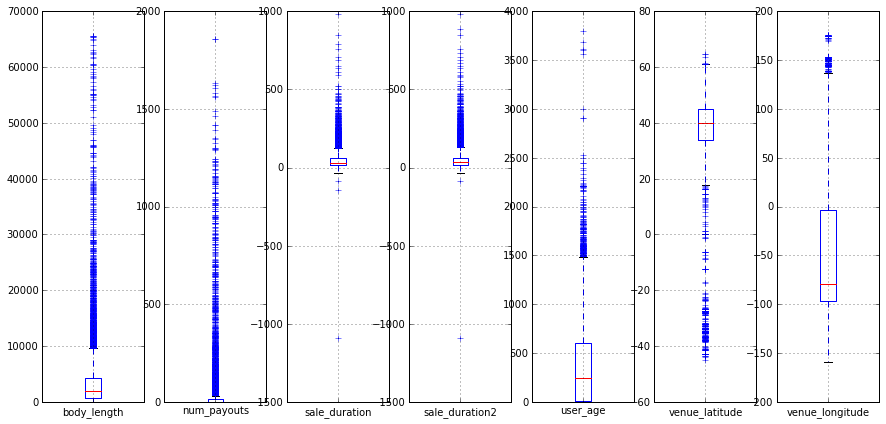

In [251]:
fig, axs = plt.subplots(1,len(non_category_variables), figsize=(15,7))
axs_ld = axs.flatten()
for i in xrange(len(non_category_variables)):
    c = non_category_variables[i]
    df[[c]].boxplot(return_type = 'axes', ax = axs_ld[i])
plt.show()

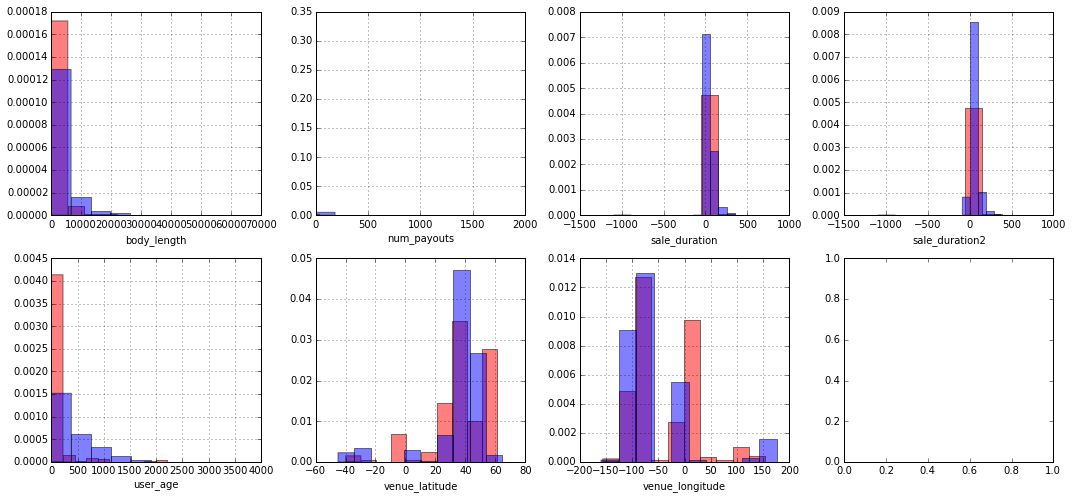

In [243]:
numx_names = non_category_variables

mask = df[y_name] == True
mask2 = df[y_name] == False
fig, axs = plt.subplots(2,4, figsize=(15,7))
axs_lst = axs.flatten()
for i, xname in enumerate(numx_names):
    df[mask][xname].hist(alpha = 0.5, normed = True, ax = axs_lst[i], label='fraud',color='r')
    df[mask2][xname].hist(alpha = 0.5, normed = True, ax = axs_lst[i], label='not fraud', color='b')
    axs_lst[i].set_xlabel(xname)
plt.tight_layout()
plt.legend()

In [245]:
df[mask2].shape, df[mask].shape

((13044, 45), (1293, 45))

In [17]:
train_df3 = train_df2[['fraud'] + non_category_variables]
for feature in category_variables:
    dummy_df = pd.get_dummies(train_df2[feature], prefix =feature, dummy_na=True)
    dummy_df.drop(dummy_df.columns[:1], axis=1, inplace=True)
    train_df3 = pd.concat([train_df3, dummy_df], axis=1)
# Dropping na's
train_df3 = train_df3.dropna()

### explore Missing Values

In [58]:
# Dropping na's
train_df3 = train_df3.dropna()

In [96]:
print train_df2.shape, 'after NA:', train_df3.shape
print 'dropped %.2f%% data' % ( 100 - 100.0* train_df3.shape[0]/train_df2.shape[0])

(14337, 45) after NA: (13197, 191)
dropped 7.95% data


In [85]:
cond_kept = train_df2.index.isin(list(train_df3.index))

In [86]:
pd.value_counts(train_df2[-cond_kept][y_name])

False    740
True     400
dtype: int64

In [97]:
pd.value_counts(train_df2[cond_kept][y_name])

False    12304
True       893
dtype: int64

In [87]:
train_df2[- cond_kept][non_category_variables].head(3).T

,3,33,48
body_length,12347,4847,617
num_payouts,16,0,1
sale_duration,0,47,49
sale_duration2,0,70,49
user_age,889,91,848
venue_latitude,NaN,NaN,NaN
venue_longitude,NaN,NaN,NaN


In [88]:
train_df2[- cond_kept][category_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
channels,1140,3.618421,4.205541,0,0,0,8,13
delivery_method,1130,0.275221,0.464322,0,0,0,1,3
fb_published,1140,0.012281,0.110184,0,0,0,0,1
has_analytics,1140,0.042105,0.200917,0,0,0,0,1
has_header,616,0.134740,0.341723,0,0,0,0,1
has_logo,1140,0.632456,0.482348,0,0,1,1,1
show_map,1140,0.386842,0.487241,0,0,0,1,1
user_type,1140,2.385088,1.202115,1,1,3,3,5


In [90]:
train_df2[- cond_kept][non_category_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
body_length,1140,2669.134211,6915.407271,0.000000,0.000000,316.000000,2563.750000,60300.000000
num_payouts,1140,34.898246,136.138216,0.000000,0.000000,1.000000,11.000000,1145.000000
sale_duration,985,27.387817,63.388480,-1094.000000,1.000000,10.000000,38.000000,611.000000
sale_duration2,1140,30.632456,61.789448,-1094.000000,1.000000,17.000000,40.000000,611.000000
user_age,1140,298.516667,392.071770,0.000000,1.750000,112.500000,487.250000,2911.000000
venue_latitude,64,38.123189,16.934896,-37.813742,38.020650,40.744947,51.500010,56.392734
venue_longitude,64,-51.160959,48.123146,-122.342484,-79.371279,-73.988806,-0.116698,144.968309


In [89]:
train_df2[cond_kept][category_variables + non_category_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
channels,13197,6.397666,3.748164,0.000000,5.000000,6.000000,8.000000,13.000000
delivery_method,13191,0.453643,0.599052,0.000000,0.000000,0.000000,1.000000,3.000000
fb_published,13197,0.137380,0.344261,0.000000,0.000000,0.000000,0.000000,1.000000
has_analytics,13197,0.075699,0.264526,0.000000,0.000000,0.000000,0.000000,1.000000
has_header,8312,0.207050,0.405216,0.000000,0.000000,0.000000,0.000000,1.000000
has_logo,13197,0.860195,0.346797,0.000000,1.000000,1.000000,1.000000,1.000000
show_map,13197,0.883686,0.320614,0.000000,1.000000,1.000000,1.000000,1.000000
user_type,13197,2.739259,1.633978,1.000000,3.000000,3.000000,3.000000,103.000000
body_length,13197,3759.197848,5638.964552,0.000000,865.000000,2099.000000,4417.000000,65535.000000
num_payouts,13197,33.654391,124.191883,0.000000,0.000000,2.000000,13.000000,1858.000000


In [63]:
pd.value_counts(train_df2[cond_kept][y_name])

False    12304
True       893
dtype: int64

In [98]:
pd.value_counts(train_df2.acct_type)

premium             12373
fraudster_event       851
fraudster             437
spammer_limited       218
spammer_warn          144
tos_warn               91
spammer_noinvite       84
tos_lock               77
locked                 54
fraudster_att           5
spammer_web             2
spammer                 1
dtype: int64

In [99]:
train_df2['fraud'].head()

0     True
1    False
2    False
3    False
4    False
Name: fraud, dtype: bool

### feature importance

In [19]:
# getting X & y for the train set
y = np.array(train_df3.fraud)
X = train_df3.drop(['fraud'], axis=1).values

In [55]:
feature_names = train_df3.columns[1:]
y_name = 'fraud'
#print feature_names

In [21]:
# Using the random forest to find out the feature importances.
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

In [22]:
rf = rf.fit(X, y)

In [23]:
feature_names[np.argsort(rf.feature_importances_)[::-1]][:10]

Index([u'sale_duration2', u'sale_duration', u'user_age', u'body_length', u'venue_longitude', u'venue_latitude', u'num_payouts', u'payout_type_ACH', u'payout_type_CHECK', u'user_type_3.0'], dtype='object')

In [38]:
len(feature_names)

190

In [41]:
importances[sorted_idx]

array([ 0.18171947,  0.16905349,  0.10262116,  0.06492819,  0.05862069,
        0.05477051,  0.05451729,  0.0374991 ,  0.02547588,  0.02293755,
        0.02175938,  0.0132344 ,  0.01246519,  0.01174063,  0.0087612 ,
        0.00820341,  0.00820178,  0.00819389,  0.00725646,  0.00718293,
        0.00666445,  0.00658548,  0.00637972,  0.00625165,  0.00606532,
        0.00599759,  0.00587649,  0.00580828,  0.00577229,  0.00499129,
        0.00490946,  0.00326148,  0.00325447,  0.0029622 ,  0.00292172,
        0.0025512 ,  0.00254467,  0.00251498,  0.00234306,  0.00213167,
        0.00212826,  0.00193234,  0.0018361 ,  0.00181787,  0.00176725,
        0.00166418,  0.00146795,  0.00124257,  0.00106813,  0.00099989])

[]

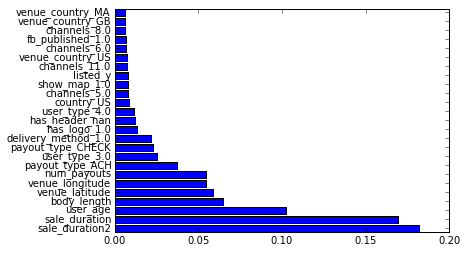

In [80]:
topk = 25
plt.figure(figsize=(50,70))
importances = rf.feature_importances_
sorted_idx = np.argsort(-1.0* importances)[:topk]
padding = np.arange(len(sorted_idx)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.yticks(padding, feature_names[sorted_idx])
plt.plot()

In [40]:
importances[0]

0.064928193680148794

In [24]:
rf = rf.fit(X, y)
rf.oob_score_

0.9762824884443434

In [275]:
def modify_train(train_df2, non_category_variables, category_variables):
    train_df3 = train_df2[['fraud'] + non_category_variables]

    for feature in category_variables:
        dummy_df = pd.get_dummies(train_df2[feature], prefix =feature, dummy_na=True)
        dummy_df.drop(dummy_df.columns[:1], axis=1, inplace=True)
        train_df3 = pd.concat([train_df3, dummy_df], axis=1)
    # Dropping na's
    train_df3 = train_df3.dropna()
    
    return train_df3

In [274]:
train_df3.columns

Index([u'fraud', u'body_length', u'num_payouts', u'sale_duration', u'sale_duration2', u'user_age'], dtype='object')

## model evaluation

In [277]:
#train_df3 = train_df2[['fraud'] + non_category_variables]
category_variables = ['channels', 'country', 'currency', 'delivery_method', 
                      'fb_published', 'has_analytics', 'has_header', 
                      'has_logo', 'listed', 'payout_type', 'show_map', \
                      'user_type', 'venue_country']
non_category_variables = ['body_length', 'num_payouts', 'sale_duration', 'sale_duration2', 
                          'user_age'] #, 'venue_latitude', 'venue_longitude']


from sklearn.cross_validation import train_test_split

train_df3 = modify_train(train_df2, non_category_variables, category_variables)

y = np.array(train_df3.fraud)
#X = train_df3.drop(['fraud'], axis=1).values
#X = train_df3[non_category_variables ]

X = train_df3.drop(['fraud'], axis=1).values
train_X, test_X, train_y, test_y = train_test_split(X, \
                                                    y, test_size=0.25)
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf = rf.fit(train_X, train_y)
test_y_pred_prob = rf.predict_proba(test_X)[:,1] 
test_y_pred = rf.predict(test_X) 

In [278]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

print 'confusion_matrix: \n', confusion_matrix(test_y, test_y_pred)
print 'accuracy: ', accuracy_score(test_y, test_y_pred) 
print 'precision: ', precision_score(test_y, test_y_pred, average='binary')
print 'recall: ', recall_score(test_y, test_y_pred)

confusion_matrix: 
[[3244   19]
 [  61  222]]
accuracy:  0.977439368302
precision:  0.921161825726
recall:  0.78445229682


[]

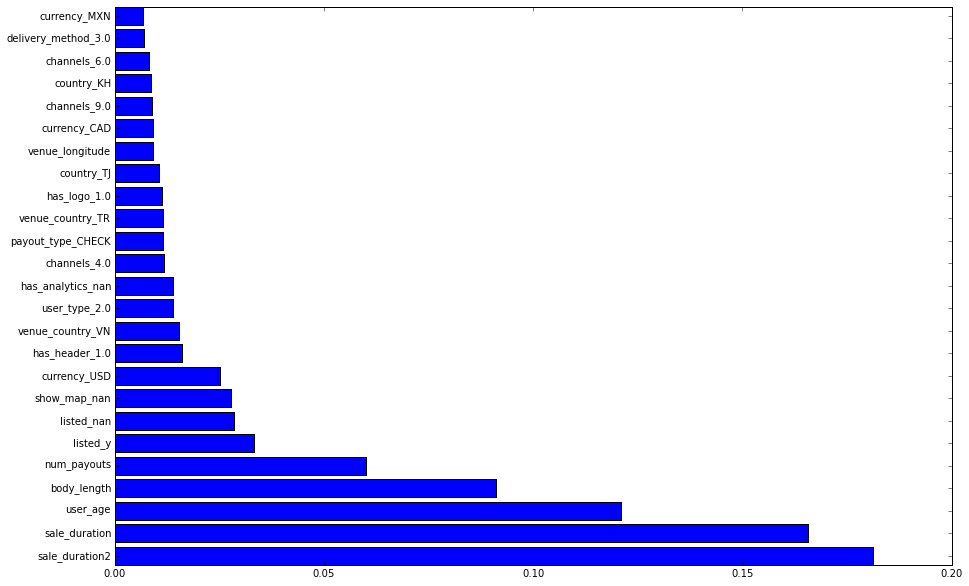

In [282]:
topk = 25
plt.figure(figsize=(15,10))
importances = rf.feature_importances_
sorted_idx = np.argsort(-1.0* importances)[:topk]
padding = np.arange(len(sorted_idx)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.tick_params(axis='y', which='major', labelsize=10)
plt.yticks(padding, feature_names[sorted_idx])
plt.plot()

## test out different models

In [293]:
# compare 3 classification methods:
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
estimators = [\
            DecisionTreeClassifier(max_depth=5) ]#,
 '''
            RandomForestClassifier( n_estimators=100),
            RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
            linear_model.LogisticRegression(),
            linear_model.LogisticRegression(c=0.1),
            KNeighborsClassifier(5),
            AdaBoostClassifier(),
            clf = GradientBoostingClassifier() ,
            KNeighborsClassifier(3),
            GaussianNB(),
            LDA(),
            QDA(),
            SVC(kernel="linear", C=0.025)
'''
#    ]

In [295]:
estimators = [GradientBoostingClassifier() ,
              DecisionTreeClassifier(max_depth=5),
             RandomForestClassifier( n_estimators=100),
              RandomForestClassifier(max_depth=5, n_estimators=300, max_features=1),
                            AdaBoostClassifier(), 
              
              linear_model.LogisticRegression(),
              linear_model.LogisticRegression(C=0.1),
              
              KNeighborsClassifier(5),
             
              GaussianNB(),
              LDA(),
              QDA(),
              
              SVC(kernel="linear", C=0.025),
             ]
X = StandardScaler().fit_transform(X)
for estimator in estimators:
    try:
        score = cross_val_score(estimator, X, y, cv = 10).mean()
        print("Score for %s:  %.3f" % (estimator.__class__.__name__, score))
    except:
        pass
    
train_y_pred_lst = []
test_y_pred_1st = []
estimators_fitted = []

train_X, test_X, train_y, test_y = train_test_split(X, \
                                                    y, test_size=0.25)
for estimator in estimators:
    try:
        estimator = estimator.fit(train_X, train_y)
        estimators_fitted.append(estimator)
        train_y_pred_lst.append(estimator.fit(train_X))
        test_y_pred_lst.append(estimator.fit(test_X))
        print '\n model: %s'  %(estimator.__class__.__name__)
        print 'confusion_matrix: \n', confusion_matrix(test_y, test_y_pred)
        print 'accuracy: ', accuracy_score(test_y, test_y_pred) 
        print 'precision: ', precision_score(test_y, test_y_pred, average='binary')
        print 'recall: ', recall_score(test_y, test_y_pred)
    except:
        pass

Score for GradientBoostingClassifier:  0.970
Score for DecisionTreeClassifier:  0.958
Score for RandomForestClassifier:  0.972
Score for RandomForestClassifier:  0.917
Score for AdaBoostClassifier:  0.964
Score for LogisticRegression:  0.954
Score for LogisticRegression:  0.953
Score for KNeighborsClassifier:  0.954
Score for GaussianNB:  0.242
Score for LDA:  0.930
Score for QDA:  0.253
Score for SVC:  0.944


In [303]:
estimators = [
              DecisionTreeClassifier(max_depth=5)  ,

             RandomForestClassifier( n_estimators=100),

              RandomForestClassifier(max_depth=5, n_estimators=300),
                            AdaBoostClassifier(), 
              
    GradientBoostingClassifier() ,
    
              linear_model.LogisticRegression(),
              linear_model.LogisticRegression(C=0.1),
              
              KNeighborsClassifier(5),
             
              GaussianNB(),
              LDA(),
              QDA(),
              
              SVC(kernel="linear", C=0.025),
             ]

train_y_pred_lst = []
test_y_pred_lst = []
estimators_fitted = []

train_X, test_X, train_y, test_y = train_test_split(X, \
                                                    y, test_size=0.25)
for i, estimator in enumerate(estimators):

    estimator = estimator.fit(train_X, train_y)
    estimators_fitted.append(estimator)
    train_y_pred_lst.append(estimator.predict(train_X))
    test_y_pred_lst.append(estimator.predict(test_X))
    print '\n model: %s'  %(estimator.__class__.__name__)
    print 'confusion_matrix: \n', confusion_matrix(test_y, test_y_pred_lst[i])
    print 'accuracy: ', accuracy_score(test_y, test_y_pred_lst[i]) 
    print 'precision: ', precision_score(test_y, test_y_pred_lst[i], average='binary')
    print 'recall: ', recall_score(test_y, test_y_pred_lst[i])



 model: DecisionTreeClassifier
confusion_matrix: 
[[3177   59]
 [  82  228]]
accuracy:  0.960236886633
precision:  0.794425087108
recall:  0.735483870968

 model: RandomForestClassifier
confusion_matrix: 
[[3211   25]
 [  70  240]]
accuracy:  0.973209249859
precision:  0.905660377358
recall:  0.774193548387

 model: RandomForestClassifier
confusion_matrix: 
[[3235    1]
 [ 252   58]]
accuracy:  0.928652002256
precision:  0.983050847458
recall:  0.187096774194

 model: AdaBoostClassifier
confusion_matrix: 
[[3198   38]
 [  93  217]]
accuracy:  0.963056965595
precision:  0.850980392157
recall:  0.7

 model: GradientBoostingClassifier
confusion_matrix: 
[[3204   32]
 [  73  237]]
accuracy:  0.970389170897
precision:  0.881040892193
recall:  0.764516129032

 model: LogisticRegression
confusion_matrix: 
[[3206   30]
 [ 142  168]]
accuracy:  0.95149464185
precision:  0.848484848485
recall:  0.541935483871

 model: LogisticRegression
confusion_matrix: 
[[3212   24]
 [ 157  153]]
accuracy:  0

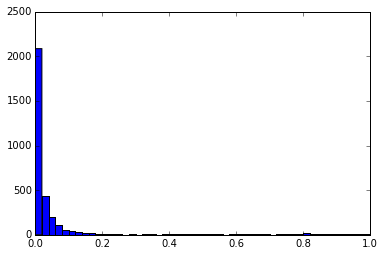

In [133]:
plt.hist(test_y_pred_prob[:,1], bins = 50)
plt.show()

In [237]:
def confusion_rates2(cm):
    [[tn, fp], [fn, tp]] = cm

    N = fp + tn
    P = tp + fn

    tpr = tp / P
    fpr = fp / N
    fnr = fn / P
    tnr = tn / N

    return np.array([[tpr, fpr], [fnr, tnr]])


def profit_curve2(y_actual, y_pred_lst, cb): 
    pos = np.sum(y_actual == 1) / len(y_actual)
    neg = 1 - pos
    class_probs = np.array([pos, neg])
    
    tmp = []
    for probabilities  in y_pred_lst:
        indicies = np.argsort(probabilities)[::-1]

        profit = []
        for i in xrange(len(indicies)):
            pred_false = indicies[i:]
            y_predict = np.ones(len(indicies))
            y_predict[pred_false] = 0
            rates = confusion_rates2(confusion_matrix(y_actual, y_predict))
            profit.append(np.sum(class_probs * rates * cb))
            
        print max(profit)
        i_max_profit2 = np.argmax(profit)
        probs = np.array(probabilities)
        print '%i max profit: %.2f  cutoff: %.2f ' % (i_max_profit2, profit[i_max_profit2], probs[i_max_profit2])
        percentages = np.arange(len(indicies)) / len(indicies) * 100
        plt.plot(percentages, profit, label= 'label')
        tmp.append([percentages, profit])

    plt.legend(loc="lower right")
    plt.title("Profits of classifiers")
    plt.xlabel("Percentage of test instances (decreasing by score)")
    plt.ylabel("Profit")
    #plt.ylim(20)
    plt.show()
    return tmp



In [208]:
def confusion_matrix_fixed(cm):
    [[tn, fp], [fn, tp]] = cm
    #[[tn,fp],[fn,tp]]
    return np.array([[tp, fp], [fn, tn]])

-0.404545454545
253 max profit: -0.40  cutoff: 0.02 


NameError: global name 'precentages' is not defined

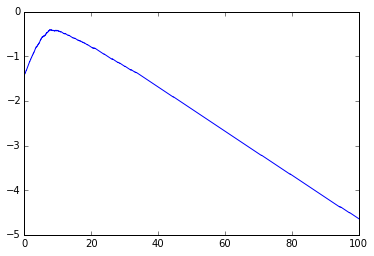

In [236]:
avg_loss_per_fraud = -20  # false negative
avg_cost_fp = -5  # false positive
# cost - benefit matrix
cb = np.array([[0, avg_cost_fp],[avg_loss_per_fraud, 0]])
tmp2 = profit_curve2( test_y, [test_y_pred_prob],cb)
plt.show()

In [234]:
print len(tmp2[0][0]), max(tmp2[0][0])
print len(tmp2[0][1]), max(tmp2[0][1])

TypeError: 'NoneType' object has no attribute '__getitem__'

In [229]:
cutoff = 0.02
indicies = np.argsort(test_y_pred_prob)[::-1]
print sum(np.array(test_y_pred_prob) >0)
print len(test_y_pred_prob)
print test_y_pred_prob[indicies[3290:3305]]

def exp_profit(y_actual, y_pred, cb):
    pos = np.sum(y_actual == 1) / len(y_actual)
    neg = 1 - pos
    class_probs = np.array([pos, neg])    
    rates = confusion_rates2(confusion_matrix(y_actual, y_predict))
    return (np.sum(class_probs * rates * cb))

1358
3300
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [170]:
indicies = np.argsort(test_y_pred_prob)

In [114]:
pd.value_counts(test_y_pred)

False    12304
True       893
dtype: int64

In [155]:
1.0 * ( 85 * (-20) + (27 * (-5))) / 3300

-0.556060606060606

In [210]:
from sklearn.metrics import confusion_matrix
print confusion_matrix(test_y, test_y_pred)
print confusion_matrix_fixed(confusion_matrix(test_y, test_y_pred))

[[3039   25]
 [  95  141]]
[[ 141   25]
 [  95 3039]]


In [214]:
print 141+95, 25+3039, 236+3064

236 3064 3300


In [215]:
print 236* (-20) / 3300,  3036* (-5) / 3300

-1.4303030303 -4.6


In [209]:
from __future__ import division
print confusion_rates(confusion_matrix(test_y, test_y_pred))
print confusion_rates2(confusion_matrix(test_y, test_y_pred))

[[ 0.59745763  0.00815927]
 [ 0.40254237  0.99184073]]
[[ 0.59745763  0.00815927]
 [ 0.40254237  0.99184073]]


In [47]:
test_df.head(2).T

,0,1
acct_type,premium,premium
approx_payout_date,1364342400,1366081200
body_length,12207,2287
channels,11,8
country,US,US
currency,USD,USD
delivery_method,0,1
description,"<p class=""MsoPlainText"" style=""margin: 0in 0in...","<h1><span style=""color: #f27c60;"">Office Desig..."
email_domain,outlook.com,betamore.com
event_created,1360961816,1360959297


In [27]:
train_df.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{u'event_id': 885645, u'cost': 25.0, u'availa...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{u'event_id': 1114349, u'cost': 150.0, u'avai...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA


In [100]:
pd.value_counts(test_df.acct_type)

premium             3072
fraudster_event      196
fraudster            131
spammer_limited       73
spammer_warn          37
locked                24
tos_warn              19
spammer_noinvite      16
tos_lock              16
spammer                1
dtype: int64

model 1:

`
    confusion_matrix: 
    [[3050   19]
     [  62  169]]
    accuracy:  0.975454545455
    precision:  0.898936170213
    recall:  0.731601731602
`
    
model 2 (continuous variables only)

`
    confusion_matrix: 
    [[3042   27]
     [  85  146]]
    accuracy:  0.966060606061
    precision:  0.843930635838
    recall:  0.63203463203
`

model 3 (model 1 - lattitude/longitude)  
`
       confusion_matrix: 
    [[3244   19]
     [  61  222]]
    accuracy:  0.977439368302
    precision:  0.921161825726
    recall:  0.78445229682
`


In [211]:
# code verfication
y_true =    [1, 1, 1, 1, 1, 0, 0]

y_predict = [1, 1, 1, 1, 0, 0, 0]

conf_mat = confusion_matrix(y_true, y_predict)
print conf_mat
print confusion_matrix_fixed(conf_mat)
print confusion_rates(conf_mat)

[[2 0]
 [1 4]]
[[4 0]
 [1 2]]
[[ 0.8  0. ]
 [ 0.2  1. ]]


In [266]:
['a','b']-['a']

TypeError: unsupported operand type(s) for -: 'list' and 'list'